In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import CIFAR10
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torchvision.utils import make_grid
from train import *

sys.path.append('./AnoGAN')

from train_fanogan import train_f_encoder

from model import *
from utils import custom_data,weights_init,display_image,transform_data

c:\Users\icako\anaconda3\envs\anogan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
latent_dim=128
channels=3
is_color=True
lr=0.0001
batchsize=128
image_size=64
epochs=200
kappa=1.0
transform=transform_data(image_size)

In [3]:
train_dataset = CIFAR10(root='../data/', train=True, download=True)

x_train=torch.ByteTensor(train_dataset.data[torch.tensor(train_dataset.targets)==1])
x_train_normal, x_valid_normal = x_train.split((int(len(x_train) * 0.8)), dim=0)

y_train=torch.ByteTensor(train_dataset.targets)[torch.tensor(train_dataset.targets)==1]
y_traiin_normal, y_valid_normal = y_train.split((int(len(y_train) * 0.8)), dim=0)

data=custom_data(x_train_normal,y_traiin_normal,transform=transform)
train_loader_normal = DataLoader(data, batch_size=batchsize, shuffle=True)

val_dataset = CIFAR10(root='../data/', train=False, download=True)

x_train_ab=torch.ByteTensor(train_dataset.data[torch.tensor(train_dataset.targets)!=1])
y_train_ab=torch.ByteTensor(train_dataset.targets)[torch.tensor(train_dataset.targets)!=1]


device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
G = generator(latent_dim=latent_dim, last_dim=image_size, is_color=is_color, bias=False).to(device)
D = Discriminator(imgsize=image_size, is_color=is_color, bias=False).to(device)

In [5]:
G.load_state_dict(torch.load('./model_saves/permanent/Generator_best_mnist.pt'))
D.load_state_dict(torch.load('./model_saves/permanent/Discriminator_best_mnist.pt'))

<All keys matched successfully>

In [6]:
E,loss=train_f_encoder(G=G,D=D,epochs=epochs,kappa=kappa,lr=lr,train_loader=train_loader_normal,
                device=device,latent_dim=latent_dim,channels=channels,img_size=image_size)

Encoder Loss at 1 epoch iteration 0 is 1.4711
Encoder Loss at 1 epoch iteration 5 is 0.8741
Encoder Loss at 1 epoch iteration 10 is 0.7316
Encoder Loss at 1 epoch iteration 15 is 0.6557
Encoder Loss at 1 epoch iteration 20 is 0.5944
Encoder Loss at 1 epoch iteration 25 is 0.5806
Encoder Loss at 1 epoch iteration 30 is 0.5395
Best Model Renewed at 1 with 0.7142
Encoder Loss at 2 epoch iteration 0 is 0.6434
Encoder Loss at 2 epoch iteration 5 is 0.5313
Encoder Loss at 2 epoch iteration 10 is 0.5190
Encoder Loss at 2 epoch iteration 15 is 0.4815
Encoder Loss at 2 epoch iteration 20 is 0.4977
Encoder Loss at 2 epoch iteration 25 is 0.5573
Encoder Loss at 2 epoch iteration 30 is 0.5123
Best Model Renewed at 2 with 0.5078
Encoder Loss at 3 epoch iteration 0 is 0.5410
Encoder Loss at 3 epoch iteration 5 is 0.4923
Encoder Loss at 3 epoch iteration 10 is 0.4848
Encoder Loss at 3 epoch iteration 15 is 0.4440
Encoder Loss at 3 epoch iteration 20 is 0.4172
Encoder Loss at 3 epoch iteration 25 is 0

## AnoGAN Reconstruction using trained latent vector

In [13]:
data=custom_data(x_train_normal[0].unsqueeze(0),torch.zeros((1,)),transform=transform)
train_loader_normal = DataLoader(data, batch_size=1, shuffle=True)

In [16]:
C=train(latent_dim=latent_dim, img_size=image_size, is_color=is_color, device=device)
xx,yy,z,loss=C.latent_mapping(train_loader_normal,alpha=0.5,D=D,G=G,iteration=800,save_logs=False)

Loss for 1 Batch / 1 at 0 iteration is 76.7946
Loss for 1 Batch / 1 at 200 iteration is 65.0060
Loss for 1 Batch / 1 at 400 iteration is 59.2228
Loss for 1 Batch / 1 at 600 iteration is 54.0613
Final Anomaly Loss for Batch 1 / 1 is 51.0548
Optimization Completed


## F-AnoGAN reconstruction using trained Encoder

In [17]:
transform=transforms.Compose(
        [
        transforms.ToPILImage(),
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

img_vec=transform(x_train_normal[0].permute(2,1,0)).unsqueeze(0).to(device)
E = Encoder(latent_dim, image_size, 3, bias=False).to(device)
E.load_state_dict(torch.load('./f-anogan/logs2/model_saves/Encoder.pt'))
G.eval()
E.eval()
with torch.no_grad():
    output_fanogan=G(E(img_vec)).detach().cpu()
    output_anogan=G(torch.tensor(z).squeeze(0).to(device)).detach().cpu()

In [18]:
from torchvision.utils import make_grid


anooutput=make_grid(output_anogan,normalize=True).permute(1,2,0)
foutput=make_grid(output_fanogan,normalize=True).permute(1,2,0)


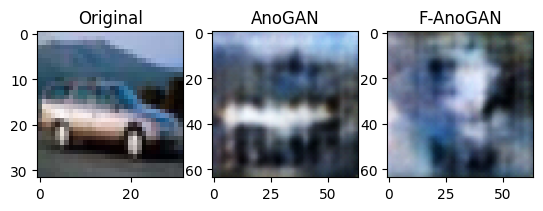

In [19]:
fig, axs = plt.subplots(1, 3)
axs[0].title.set_text('Original')
axs[1].title.set_text('AnoGAN')
axs[2].title.set_text('F-AnoGAN')

axs[0].imshow(x_train_normal[0])
axs[1].imshow(anooutput)
axs[2].imshow(foutput)